## Importing Libraries

In [1434]:
# imports and constants

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipkinc, ellipj
import mpmath
import sympy as sp
from scipy.optimize import fsolve

M = 1

## Defining necessary functions

### Desmos Graph

This is a plot of the function below animated between $0 < \alpha < 2\pi$. The figure clearly shows that the function approaches $\pi / 2$ as $\theta_0$ approaches $0$.

$$\gamma = \arccos\left(\frac{\cos\left(\alpha\right)}{\sqrt{\cos\left(\alpha\right)^{2}+\cot\left(\theta_0\right)^{2}}}\right)$$

<center>
    <iframe src="https://www.desmos.com/calculator/mtqcqypm6b?embed" width="300" height="300" style="border: 0px solid #ccc" frameborder=0></iframe>
</center>

In [1435]:
def _gamma(alpha, theta):
    if theta == 0:
        return np.pi/2 # avoid undefined behavior 
    

    return np.arccos(
        np.cos(alpha) / np.emath.sqrt(np.cos(alpha) ** 2 + 1 / np.tan(theta) ** 2)
    )


def _radius(P, alpha, theta, debug=False):
    # assert P >= 3 * M, "Closest approach must be greater than 3*M."

    Q = np.emath.sqrt((P - 2 * M) * (P + 6 * M))
    gamma = _gamma(alpha, theta)

    term_1 = (Q - P + 2 * M) / (4 * M * P)
    term_2 = (Q - P + 6 * M) / (4 * M * P)

    k_squared = (Q - P + 6 * M) / (2 * Q)

    sin_squared_zeta = (Q - P + 2 * M) / (Q - P + 6 * M)
    zeta = np.arcsin(np.emath.sqrt(sin_squared_zeta))


    if P <= 30000*M:
        np_ellipf = np.frompyfunc(mpmath.ellipf, 2, 1)
        F = np.complex128(np_ellipf(zeta, k_squared))

        u = gamma / 2 * np.emath.sqrt(P / Q) + F
        np_ellipj = np.frompyfunc(mpmath.ellipfun, 3, 1)
        sn = np.complex128(np_ellipj('sn', u, k_squared))
    else:
        F = ellipkinc(zeta, k_squared)

        u = gamma / 2 * np.emath.sqrt(P / Q) + F
        sn, _, _, _ = ellipj(u, k_squared)

    if debug:
        print(f"Q: {Q}")
        print(f"gamma: {gamma}")
        print(f"term_1: {term_1}")
        print(f"term_2: {term_2}")
        print(f"k^2: {k_squared}")
        print(f"zeta: {zeta}")
        print(f"F: {F}")
        print(f"u: {u}")
        print(f"sn: {sn}")

    radius = np.abs(1 / (-term_1 + term_2 * sn**2))

    return radius


def _impact_parameter(P):
    return np.emath.sqrt(P**3 / (P - 2 * M))

## Inverting equation (5) to get $P(b)$

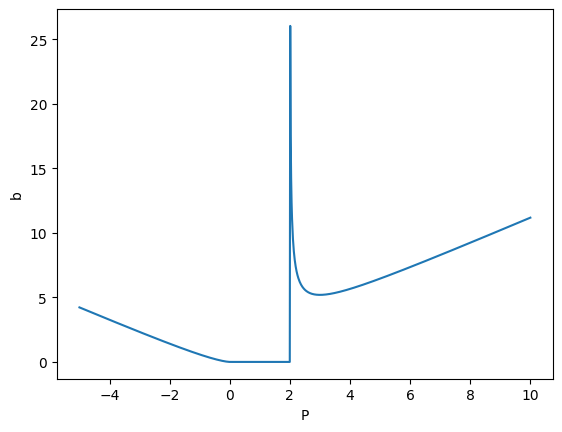

In [1436]:
# plot the impact parameter b as a function of P

P = np.linspace(-5*M, 10*M, 1000)

plt.plot(P, np.real(_impact_parameter(P)))

plt.xlabel("P")
plt.ylabel("b")

plt.show()

Rewrite equation 5 in the form of a cubic equation for P.
It seems the equation in the paper is incorrect as the minimum value of $b$ would be $27$ which should be $\sqrt{27}$. 

\begin{align*}
	b &= \frac{P^3}{P-2M}\\
	bP - 2Mb &= P^3\\
	P^3 - bP + 2Mb &=0.
\end{align*}

Rewrite equation 5 in the form of a cubic equation for P.
This is probably the correct equation.

\begin{align*}
	b^2 &= \frac{P^3}{P-2M}\\
	b^2P - 2Mb^2 &= P^3\\
	P^3 - b^2P + 2Mb^2 &=0.
\end{align*}

-b**2/((-1/2 + sqrt(3)*I/2)*(27*M*b**2 + sqrt(2916*M**2*b**4 - 108*b**6)/2)**(1/3)) - (-1/2 + sqrt(3)*I/2)*(27*M*b**2 + sqrt(2916*M**2*b**4 - 108*b**6)/2)**(1/3)/3


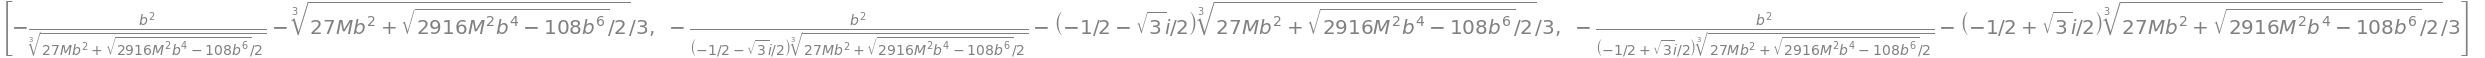

In [1437]:
# solve b(P) for P

sp.init_printing()

sp_P, sp_b, sp_M = sp.symbols("P b M")

eq = sp_P**3 - sp_b**2 * sp_P + 2 * sp_M * sp_b**2

solutions = sp.solve(eq, sp_P)
print(solutions[2])
solutions

In [1438]:
# define all solutions of b(P) for P derived with sympy


def P1(b, M):
    return (
        -(b**2)
        / (27 * M * b**2 + np.emath.sqrt(2916 * M**2 * b**4 - 108 * b**6) / 2)
        ** (1 / 3)
        - (27 * M * b**2 + np.emath.sqrt(2916 * M**2 * b**4 - 108 * b**6) / 2)
        ** (1 / 3)
        / 3
    )


def P2(b, M):
    vals = (
        -(b**2)
        / (
            (-1 / 2 - np.emath.sqrt(3) * 1j / 2)
            * (27 * M * b**2 + np.emath.sqrt(2916 * M**2 * b**4 - 108 * b**6) / 2)
            ** (1 / 3)
        )
        - (-1 / 2 - np.emath.sqrt(3) * 1j / 2)
        * (27 * M * b**2 + np.emath.sqrt(2916 * M**2 * b**4 - 108 * b**6) / 2)
        ** (1 / 3)
        / 3
    )

    # return vals

    return np.real(vals)



def P3(b, M):
    vals = (
        -(b**2)
        / (
            (-1 / 2 + np.emath.sqrt(3) * 1j / 2)
            * (27 * M * b**2 + np.emath.sqrt(2916 * M**2 * b**4 - 108 * b**6) / 2)
            ** (1 / 3)
        )
        - (-1 / 2 + np.emath.sqrt(3) * 1j / 2)
        * (27 * M * b**2 + np.emath.sqrt(2916 * M**2 * b**4 - 108 * b**6) / 2)
        ** (1 / 3)
        / 3
    )

    return vals

    # return [
    #     np.nan if not np.allclose(np.imag(val), 0, 1e-60) else np.real(val)
    #     for val in vals
    # ]

/home/koen/school/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/koen/school/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


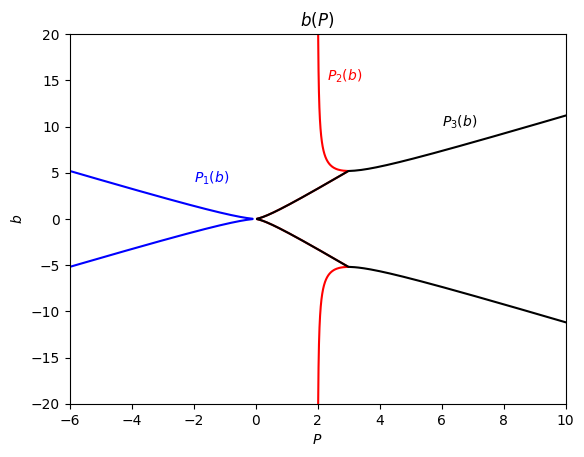

In [1439]:
# plot solutions of b(P) for P derived with sympy

b = np.linspace(-20, 20, 1000)

plt.plot(np.real(P1(b, 1)), b, c='blue', linewidth=1.5)
plt.plot(P2(b, 1), b, c='red',linewidth=1.5)
plt.plot(P3(b, 1), b, c='k',linewidth=1.5)

plt.text(-2, 4, r'$P_1(b)$', rotation=0, color='blue')
plt.text(2.3, 15, r'$P_2(b)$', rotation=0, color='red')
plt.text(6, 10, r'$P_3(b)$', rotation=0)

P = np.linspace(-6*M, 10*M, 100)

# plt.plot(
#   P, get_impact_parameter(P),
#   linestyle = (0,(0.1,2)),c='white',linewidth=2.5,dash_capstyle = 'round'
# )
# plt.fill_between(P, _impact_parameter(P), 0, color='gray', alpha=0.3, label=r'$b(P)$')

plt.ylim(-20, 20)
plt.xlim(-6, 10)

plt.xlabel(r'$P$')
plt.ylabel(r'$b$')
plt.title(r'$b(P)$')

# plt.tick_params(axis='both', direction='in', top=True, right=True)

# plt.legend(frameon=False, loc='lower right')

plt.show()

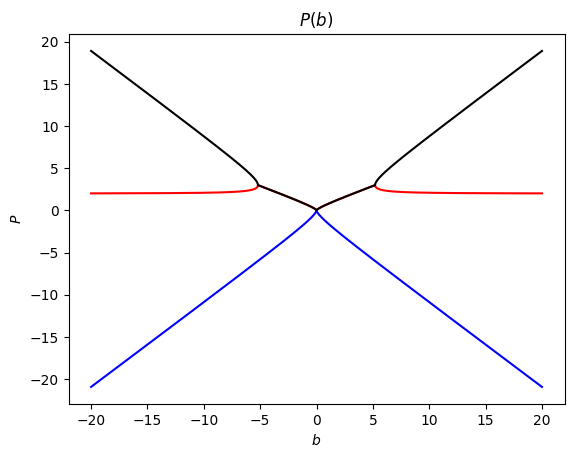

In [1440]:
# plot P(b)

plt.plot(b, P1(b,1),c='b')
plt.plot(b, P2(b,1),c='r')
plt.plot(b, P3(b,1),c='k')

plt.xlabel(r'$b$')
plt.ylabel(r'$P$')

plt.title(r'$P(b)$')
plt.show()

## Isoradial Curves

In [1441]:
def get_radius(b, alpha, theta):
    if b > 3*np.sqrt(3):
        P = P3(b, M)
    else:
        P = (P3(b,M))
    return _radius(P, alpha, theta)


def get_isoradial_curve(r, alpha, theta):
    guess = r
    solution = fsolve(lambda b, a, t: get_radius(b, a, t) - r, guess, args=(alpha, theta), maxfev=400, factor=0.1)

    return solution[0]

In [1442]:
# cosine^2-spacing as an alternative to linspace because resolution needs to be higher for angles close to 0 and pi.

def sin2space(start, stop, num):
    t = np.linspace(0, 2*np.pi, num)  # Uniform parameter
    x = np.cumsum(np.sin(t)**2)
    return x / x[-1] * (stop - start) + start  # Scale to desired range

In [ ]:
"""
okay dus boven een bepaalde r gaat het prima, eronder niet
als het onder een bepaalde waarde gaat
geeft ie iets van een error list - int not allowed
dus ergens returned ie voor P weer een lijst ipv een getal
idk wrm
doei
"""

# b = get_isoradial_curve(10, 0, 10)
fig, ax = plt.subplots(subplot_kw={'projection':'polar'})
ax.set_aspect('equal')

alpha_array = sin2space(0, 2*np.pi, 50)
r_array = [2,6,10,14,18]

for r in r_array:
    b_array = np.array([
    get_isoradial_curve(r, alpha + np.pi/2, np.deg2rad(80)) for alpha in alpha_array
    ])

    ax.set_rticks([np.sqrt(27)])
    ax.set_yticklabels([r'$b_c$'])
    ax.set_rlabel_position(280)
    ax.set_rlim(0,25)
    # x_array, y_array = b_array * np.cos(alpha_array), b_array * np.sin(alpha_array)

    plt.plot(alpha_array, b_array,c='k')



plt.show()